# EP1 - Cálculo do Conjunto de Mandelbrot em Paralelo com Pthreads e OpenMP

25 de Maio de 2020

## Membros do grupo

| Nome | NUSP |
|------|------|
| Carolina Marques | 10737101 |
| Daniela Favero | 10277443 |
| Miguel Ostrowski | 10723610 |
| Raphael Ribeiro | 10281601 |

## Pacotes Julia

Instalando os pacotes necessários que estão listados no arquivo `Project.toml`:

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %=========>                               ]  20.3 %]  40.5 %         ]  76.0 % Resolving package versions...
 Installed PlotUtils ──────── v1.0.3
 Installed SpecialFunctions ─ v0.10.1
  Updating `~/Documents/julia/concorrente-e-paralela/EP1/src/Project.toml`
 [no changes]
  Updating `~/Documents/julia/concorrente-e-paralela/EP1/src/Manifest.toml`
  [995b91a9] ↑ PlotUtils v1.0.2 ⇒ v1.0.3
  [276daf66] ↑ SpecialFunctions v0.10.0 ⇒ v0.10.1


Verificando o status dos pacotes:

In [2]:
] st

    Status `~/Documents/julia/concorrente-e-paralela/EP1/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.0
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


## Compilando

Compilando e executando os códigos C pelo *modo shell*: 


In [3]:
; make

make: Nothing to be done for 'all'.


In [4]:
; ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500 1

24.448612


Além de imprimir o tempo levado, o programa em C gera a seguinte imagem (gerada no formato ppm, tomamos liberdade para convertê-la para png e exibir aqui):

<img src="output.png" alt="mandelbrot_seq" width="400"/>

In [5]:
; ./mandelbrot_pth -2.5 1.5 -2.0 2.0 11500 4

28.489051


Imagem gerada, novamente a Full Screen, dessa vez usando 4 threads com auxílio de PThreads:

<img src="output_pth.png" alt="mandelbrot_pth" width="400"/>

In [6]:
; ./mandelbrot_omp -2.5 1.5 -2.0 2.0 11500 4

35.671782


A mesma imagem, agora gerada usando OpenMP:

<img src="output_omp.png" alt="mandelbrot_omp" width="400"/>


## Experimentos

### Funções úteis

A função abaixo recebe parâmetros `size`, com tamanho da imagem, `file`, com o nome do programa a ser executado e `threads`, com o número de threads do programa paralelo. A função executa o programa `file` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [7]:
using DataFrames, Query, StatsPlots, Statistics

function measure_mandelbrot(size, file, threads)
    results = parse.(Float64,
        split(chomp(read(`./$file -2.5 1.5 -2.0 2.0 $size $threads`, String)), ", "))
        
    return DataFrame(size = size,
        file = file,
        threads = threads,
        duration = results[1])
end

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `file`, e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [8]:
function run_experiments(size, file, threads, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int[],
        file = String[],
        threads = Int[],
        duration = Float64[])  
    
    for t in threads
        for s in size
            for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(s, file, t))    
            end
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, e produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads.

In [9]:
function parse_results_threads(results)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results_threads (generic function with 1 method)

In [10]:
function parse_results_sizes(results)
    parsed_results = results |>
                    @groupby(_.size) |>
                    @map({size = key(_),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results_sizes (generic function with 1 method)

A função `save_csv_results`recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento. A função `read_csv_results` recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [11]:
using CSV

function save_csv_results(data_frame, file)
    CSV.write(file, data_frame)
end

save_csv_results (generic function with 1 method)

In [12]:
using CSV

function read_csv_results(file)
    return CSV.read(file)
end

read_csv_results (generic function with 1 method)

A função `plot_results_threads` faz dois tipos de gráfico: ela pode mostrar todos os resultados de um experimento, marcando pontos no plano cartesiano; e também pode mostrar o resultado dado pela média e traçar uma linha vertical delimitando o intervalo de confiança do conjunto de amostras recebido.

In [13]:
pgfplotsx()

function plot_results_thread(x, y, series_label; yerror = [], max_thread_power = 5)      
    if yerror != []
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end
    return p
end

┌ Info: Precompiling PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1273
┌ Info: Precompiling Contour [d38c429a-6771-53c6-b99e-75d170b6e991]
└ @ Base loading.jl:1273


plot_results_thread (generic function with 1 method)

A função `plot_results_size` faz o mesmo que a função acima, porém com o tamanho da imagem no eixo x.

In [14]:
pgfplotsx()

function plot_results_size(x, y, series_label; yerror = [], min_size = 1500, max_size = 11500, step = 1000)      
    if yerror != []
        p = scatter(x,
            y,
            xlabel = "Sizes",
            xticks = [x for x in min_size:step:max_size],
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xlabel = "Sizes",
            xticks = [x for x in min_size:step:max_size],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end
    return p
end

plot_results_size (generic function with 1 method)

### Sequencial

Realizando os experimentos rodando a célula abaixo.

In [15]:
threads = 1
file = "mandelbrot_seq"
size = [x for x in 1500:1000:11500]
repetitions = 10

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_sizes(results)

save_csv_results(results, "results_seq.csv")
results_seq = read_csv_results("results_seq.csv")

make: Nothing to be done for 'all'.


,size,file,threads,duration
,Int64,String,Int64,Float64
1,1500,mandelbrot_seq,1,0.430324
2,1500,mandelbrot_seq,1,0.406524
3,1500,mandelbrot_seq,1,0.450715
4,1500,mandelbrot_seq,1,0.438068
5,1500,mandelbrot_seq,1,0.418583
6,1500,mandelbrot_seq,1,0.527807
7,1500,mandelbrot_seq,1,0.521239
8,1500,mandelbrot_seq,1,0.411931
9,1500,mandelbrot_seq,1,0.521926


Veja no gráfico:

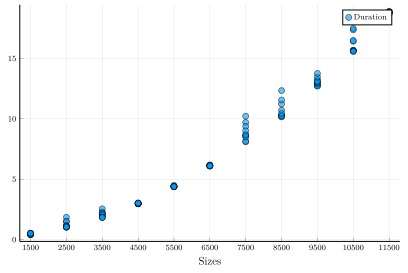

In [16]:
plot_results_size(results.size,
    results.duration,    
    "Duration",
    min_size = 1500,
    max_size = 11500,
    step = 1000)

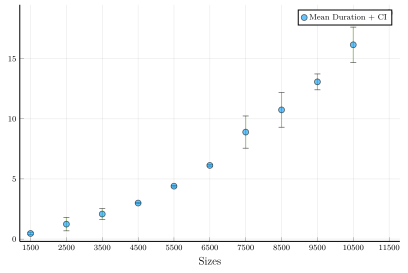

In [17]:
plot_results_size(parsed_results.size,
    parsed_results.mean_duration,    
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    min_size = 1500,
    max_size = 11500,
    step = 1000)

### PThreads
Realizando os experimentos rodando a célula abaixo, variando em número de threads.

In [18]:
size = 11500
file = "mandelbrot_pth"
threads = [2 ^ x for x in 0:5]
repetitions = 10

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "results_pth_t.csv")
results_pth_t = read_csv_results("results_pth_t.csv")

make: Nothing to be done for 'all'.


,size,file,threads,duration
,Int64,String,Int64,Float64
1,11500,mandelbrot_pth,1,18.3891
2,11500,mandelbrot_pth,1,18.1968
3,11500,mandelbrot_pth,1,18.3195
4,11500,mandelbrot_pth,1,18.1062
5,11500,mandelbrot_pth,1,18.0866
6,11500,mandelbrot_pth,1,18.1312
7,11500,mandelbrot_pth,1,18.1588
8,11500,mandelbrot_pth,1,18.4193
9,11500,mandelbrot_pth,1,18.1124


Veja no gráfico:

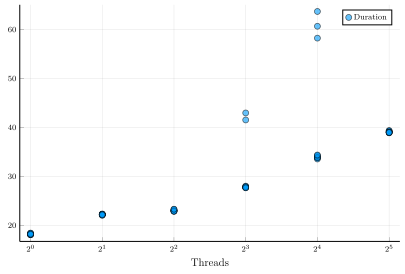

In [19]:
plot_results_thread(results.threads,
    results.duration,    
    "Duration",
    max_thread_power = 5)

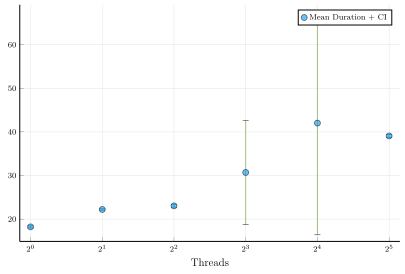

In [20]:
plot_results_thread(parsed_results.threads,
    parsed_results.mean_duration,
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    max_thread_power = 5)

Agora variando no tamanho da imagem.

In [21]:
threads = 4
file = "mandelbrot_pth"
size = [x for x in 1500:1000:11500]
repetitions = 10

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_sizes(results)

save_csv_results(results, "results_pth_s.csv")
results_pth_s = read_csv_results("results_pth_s.csv")

make: Nothing to be done for 'all'.


,size,file,threads,duration
,Int64,String,Int64,Float64
1,1500,mandelbrot_pth,4,0.384906
2,1500,mandelbrot_pth,4,0.386985
3,1500,mandelbrot_pth,4,0.386453
4,1500,mandelbrot_pth,4,0.402365
5,1500,mandelbrot_pth,4,0.399368
6,1500,mandelbrot_pth,4,0.38698
7,1500,mandelbrot_pth,4,0.386919
8,1500,mandelbrot_pth,4,0.385865
9,1500,mandelbrot_pth,4,0.385363


Veja no gráfico:

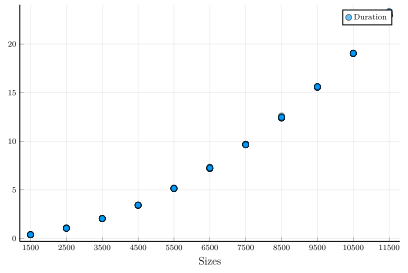

In [22]:
plot_results_size(results.size,
    results.duration,    
    "Duration",
    min_size = 1500,
    max_size = 11500,
    step = 1000)

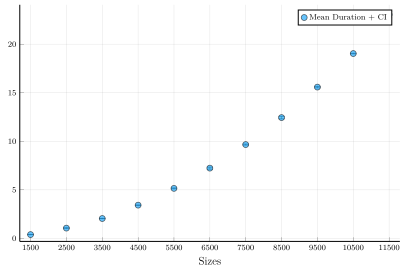

In [23]:
plot_results_size(parsed_results.size,
    parsed_results.mean_duration,    
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    min_size = 1500,
    max_size = 11500,
    step = 1000)

### OpenMP
Realizando os experimentos rodando a célula abaixo, variando em número de threads.

In [24]:
size = 11500
file = "mandelbrot_omp"
threads = [2 ^ x for x in 0:5]
repetitions = 10

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "results_omp_t.csv")
results_omp_t = read_csv_results("results_omp_t.csv")

make: Nothing to be done for 'all'.


,size,file,threads,duration
,Int64,String,Int64,Float64
1,11500,mandelbrot_omp,1,18.1594
2,11500,mandelbrot_omp,1,18.2208
3,11500,mandelbrot_omp,1,18.2942
4,11500,mandelbrot_omp,1,18.2471
5,11500,mandelbrot_omp,1,18.1234
6,11500,mandelbrot_omp,1,18.1641
7,11500,mandelbrot_omp,1,18.2025
8,11500,mandelbrot_omp,1,18.2067
9,11500,mandelbrot_omp,1,18.1695


Veja no gráfico:

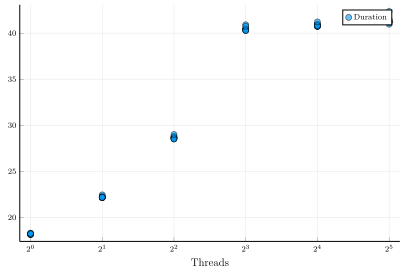

In [25]:
plot_results_thread(results.threads,
    results.duration,    
    "Duration",
    max_thread_power = 5)

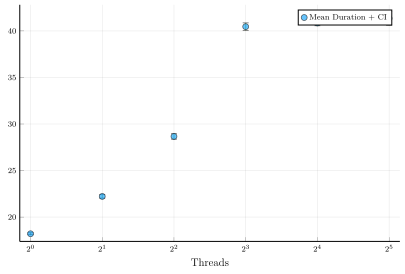

In [26]:
plot_results_thread(parsed_results.threads,
    parsed_results.mean_duration,
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    max_thread_power = 5)

Agora variando no tamanho da imagem.

In [27]:
threads = 4
file = "mandelbrot_omp"
size = [x for x in 1500:1000:11500]
repetitions = 10

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_sizes(results)

save_csv_results(results, "results_omp_s.csv")
results_omp_s = read_csv_results("results_omp_s.csv")

make: Nothing to be done for 'all'.


,size,file,threads,duration
,Int64,String,Int64,Float64
1,1500,mandelbrot_omp,4,0.357347
2,1500,mandelbrot_omp,4,0.383174
3,1500,mandelbrot_omp,4,0.404299
4,1500,mandelbrot_omp,4,0.430654
5,1500,mandelbrot_omp,4,0.440702
6,1500,mandelbrot_omp,4,0.428067
7,1500,mandelbrot_omp,4,0.429706
8,1500,mandelbrot_omp,4,0.425204
9,1500,mandelbrot_omp,4,0.421189


Veja no gráfico:

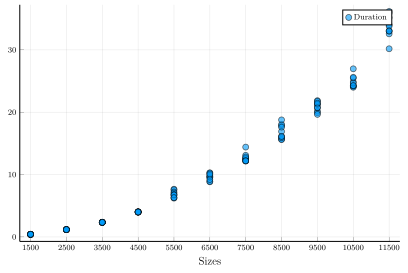

In [28]:
plot_results_size(results.size,
    results.duration,    
    "Duration",
    min_size = 1500,
    max_size = 11500,
    step = 1000)

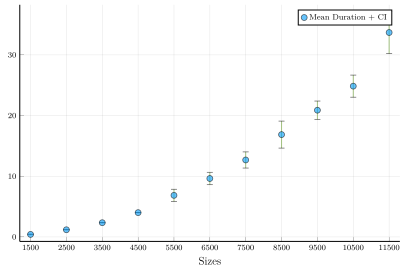

In [29]:
plot_results_size(parsed_results.size,
    parsed_results.mean_duration,    
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    min_size = 1500,
    max_size = 11500,
    step = 1000)

## Discussão

### Comportamento conforme as variações
- Como e por que as três versões do programa se comportam com a variação:
    - Do tamanho da entrada?
    - Das regiões do Conjunto de Mandelbrot?
    - Do número de threads?

### Operações I/O e alocação de memória
- O impacto das operações de I/O e alocação de memória no tempo de execução se mostra mais significativo no OpenMP porque elas são feitas de forma implícita, de modo que a medição de tempo não pode desconsiderá-las. 

- Mais perguntas interessantes...